# <font color='black'>Deep Neural Networks</font>

---
<figure>
<center>
<img src='https://drive.google.com/uc?id=1u-iZKwzco1L8a3gFFLMXbSOU_DsdNZqo' width="300" align="center" />
</center>
</figure>

> Version: **1.0**

- You need to solve this exercises in groups of two or three. 
- The first part of the evaluation, implementing a Deep neural network corresponds to 50% of the grade.
- The second part of the evaluation, answering the three exercises corresponds to 50% of the grade. The group(s) and their corresponding grade will be ranked as a function of the quality and clarity of your codes, comments and replies to the ending questions.

You can send me one solution per group to my e-mail : omar.al-hammal@ipsa.fr. 

Please format the name of the file as TP2_NAME1_NAME2_NAME3.ipynb or  TP2_NAME1_NAME2.ipynb

Good luck!


# 1 . Implementation of a Neural Network

In this exercise you will learn how to implement from scratch a deep neural network.


## Set-up

Firstly you will import all the packages used through the notebook.  

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/0IPSA/Ma512/TP/TP2/') # The location of the .ipynb file.  
import lr_utils
from utils import *

Mounted at /content/gdrive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(3)

## Initialization

Start by reading the following function. It allows to initialize the parameters of a deep neural network. The number of units in the different layers are passed as argument with `layer_dims`.


In [3]:
def initialization(layer_dims):
               
    np.random.seed(4870)
    parameters = {}
    L = len(layer_dims) - 1 # integer representing the number of layers
    
    for l in range(1, L + 1):
        ### He's initialization.
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * np.sqrt(4./(layer_dims[l-1]+layer_dims[l]))
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        ###

    assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
    assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters


## Forward propagation

The forward propagation has been split in different steps. Firstly, the linear forward module computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

Define a function to compute $Z^{[l]}$

In [4]:
def linear_forward(A, W, b):

    ### START CODE HERE ### (≈ 1 lines of code)
    Z = W@A + b
    ### END CODE HERE ###

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [5]:
A, W, b = linear_forward_test()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[-0.67356113  0.67062057]]


**Expected output**:

<table style="width:35%">
  
  <tr>
    <td> Z= </td>
    <td> [[ -0.67356113 0.67062057]] </td> 
  </tr>
  
</table>

### Activation Fcuntions

In the first notebook you implemented the sigmoid function:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$.

In this notebook, you will need to implement the ReLU activation defined as:

- **ReLU**: $A = RELU(Z) = max(0, Z)$. 

Complete the function below that computes the ReLU an activation fucntion.

In [6]:
def relu(Z):

    ### START CODE HERE ###
    A = np.maximum(0,Z)
    ### END CODE HERE ###
    
    cache = Z 
    return A, cache
def sigmoid(Z):

    cache=Z
    ### START CODE HERE ###
    A = 1/(1+np.exp(-Z))
    ### END CODE HERE ###

        
    return A, cache

You have implemented a function that determines the linear foward step. You will now combine the output of this function with either a sigmoid() or a relu() activation function. 

In [7]:
def forward_one(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

### Forward propagation model

The structure you will implement in this exercise consists on $L-1$ layers using a ReLU activation function and a last layer using a sigmoid.
Implement the forward propagation of the above model.

In [8]:
def forward_all(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                
    
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ###
        A, cache = forward_one(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        ### END CODE HERE ###
      
        caches.append(cache)   #
    ### START CODE HERE ###
    AL, cache = forward_one(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    ### END CODE HERE ###
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

###  Cost function

You will now compute the cross-entropy cost $J$, for all the training set using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [9]:
def cost_function(AL, Y):
    
    m = Y.shape[1]

    ### START CODE HERE ###
    cost = (np.sum(Y*np.log(AL)+(np.ones(Y.shape)-Y)*np.log(1-AL)))/(-m)
    ### END CODE HERE ###
    cost = np.squeeze(cost)      #  Eliminates useless dimensionality for the variable cost.
    
    return cost

In [10]:
Y, AL = compute_cost()
print("cost = " + str(cost_function(AL, Y)))

cost = 0.2797765635793423


<table>
    <tr>
    <td>**cost** </td>
    <td> 0.2797765635793422</td> 
    </tr>
</table>

##  Backpropagation 

You will now implement the functions that will help you compute the gradient of the loss function with respect to the different parameters.

To move backward in the computational graph you need to apply the chain rule.

### Linear backward

For each layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$. The formulas you saw in class are:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [11]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ###  (≈ 3 lines of code)
    dW = (1/m)*(dZ@A_prev.T)
    db = (1/m)*np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = W.T@dZ
    ### END CODE HERE ###
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [12]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 1.62477986e-01  2.08119187e+00 -1.34890293e+00 -8.08822550e-01]
 [ 1.25651742e-02 -2.21287224e-01 -5.90636554e-01  4.05614891e-03]
 [ 1.98659671e-01  2.39946554e+00 -1.86852905e+00 -9.65910523e-01]
 [ 3.18813678e-01 -9.92645222e-01 -6.57125623e-01 -1.46564901e-01]
 [ 2.48593418e-01 -1.19723579e+00 -4.44132647e-01 -6.09748046e-04]]
dW = [[-1.05705158 -0.98560069 -0.54049797  0.10982291  0.53086144]
 [ 0.71089562  1.01447326 -0.10518156  0.34944625 -0.12867032]
 [ 0.46569162  0.31842359  0.30629837 -0.01104559 -0.19524287]]
db = [[ 0.5722591 ]
 [ 0.04780547]
 [-0.38497696]]


** Expected Output**:
    
```
dA_prev = 
[[  1.62477986e-01   2.08119187e+00  -1.34890293e+00  -8.08822550e-01]
 [  1.25651742e-02  -2.21287224e-01  -5.90636554e-01   4.05614891e-03]
 [  1.98659671e-01   2.39946554e+00  -1.86852905e+00  -9.65910523e-01]
 [  3.18813678e-01  -9.92645222e-01  -6.57125623e-01  -1.46564901e-01]
 [  2.48593418e-01  -1.19723579e+00  -4.44132647e-01  -6.09748046e-04]]
dW = 
[[-1.05705158 -0.98560069 -0.54049797  0.10982291  0.53086144]
 [ 0.71089562  1.01447326 -0.10518156  0.34944625 -0.12867032]
 [ 0.46569162  0.31842359  0.30629837 -0.01104559 -0.19524287]]
db = 
[[ 0.5722591 ]
 [ 0.04780547]
 [-0.38497696]]
```

### Activation Functions

Now you need to write the code that computes the derivatives for the activation functions. You have learned the derivatives for the sigmoid and the ReLU during theory class.
Complete the two function below.

In [13]:
def sigmoid_backward(dA, cache):    
    Z = cache
    
    ### START CODE HERE ###  (≈ 2 lines of code)
    
    # dZ = np.multiply(dA,(np.ones(dA.shape)-dA))
    s = 1/(1+np.exp(-Z))
    dZ = dA*s*(1-s)
    ### END CODE HERE ###
    
    return dZ

def relu_backward(dA, cache):
    
    Z = cache 
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    ### START CODE HERE ###  (≈ 1 line of code)
    
    dZ[Z <= 0] = 0
    ### END CODE HERE ###
        
    return dZ

### One backpropagation step

Next, you will create a function that implements one step of backpropagation,

In [14]:
def backward_one(dA, cache, activation):
    linear_cache, activation_cache = cache  
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    elif activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [15]:
dAL, linear_activation_cache = linear_activation_backward_test()

dA_prev, dW, db = backward_one(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = backward_one(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.00401564  0.0404019 ]
 [-0.01386864 -0.13953419]
 [ 0.00747737  0.07523079]]
dW = [[ 0.03615272 -0.09887085  0.03247948]]
db = [[0.06684355]]

relu:
dA_prev = [[ 0.01679913  0.16610885]
 [-0.05801838 -0.57368247]
 [ 0.031281    0.30930474]]
dW = [[ 0.14820532 -0.40668077  0.13325465]]
db = [[0.27525652]]


**Expected**
sigmoid:
dA_prev = [[ 0.00401564  0.0404019 ]
 [-0.01386864 -0.13953419]
 [ 0.00747737  0.07523079]]
dW = [[ 0.03615272 -0.09887085  0.03247948]]
db = [[0.06684355]]

relu:
dA_prev = [[ 0.01679913  0.16610885]
 [-0.05801838 -0.57368247]
 [ 0.031281    0.30930474]]
dW = [[ 0.14820532 -0.40668077  0.13325465]]
db = [[0.27525652]]

### Backpropagation model

Now you will put all together to compute the backward function for the whole network. 
In the backpropagation step, you will use the variables you stored in cache in the `forward_all` function to compute the gradients. You will iterate from the last layer backwards to layer $1$.

You need to start by computing the derivative of the loss function with respect to $A^{[L]}$. And propagate this gradient backward thourgh all the layers in the network.

You need to save each dA, dW and db in the grads dictionary. 

In [16]:
def backward_all(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 

    ### START CODE HERE ###  (≈ 1 line of code)
    dAL =  -(np.divide(Y, AL)-np.divide(1-Y, 1-AL))
    ### END CODE HERE ###


    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_one(dAL, current_cache,activation="sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_one(grads["dA" + str(l + 1)],current_cache,activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [17]:
AL, Y_assess, caches = backward_all_test()
grads = backward_all(AL, Y_assess, caches)
print_grads(grads)

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


**Expected Output**

<table style="width:60%">
  <tr>
    <td > dW1 </td> 
           <td > [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]] </td> 
  </tr>  
    <tr>
    <td > db1 </td> 
           <td > [[-0.22007063]
 [ 0.        ]
 [-0.02835349]] </td> 
  </tr>   
  <tr>
  <td > dA1 </td> 
           <td > [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]] </td> 
  </tr> 
</table>



### Gradient Descent

Finally you can update the parameters of the model according: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [18]:
def gradient_descent(parameters, grads, learning_rate):
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l+1)])
    return parameters

In [19]:
parameters, grads = gradient_descent_test_case()
parameters = gradient_descent(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


**Expected Output**:

<table style="width:100%"> 
    <tr>
    <td > W1 </td> 
           <td > [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]] </td> 
  </tr> 
    <tr>
    <td > b1 </td> 
           <td > [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]] </td> 
  </tr> 
  <tr>
    <td > W2 </td> 
           <td > [[-0.55569196  0.0354055   1.32964895]]</td> 
  </tr> 
    <tr>
    <td > b2 </td> 
           <td > [[-0.84610769]] </td> 
  </tr> 
</table>

You can now create a deep neural network  combining all the functions defined above.

**Loading the dataset**

In [20]:
def load_dataset():
#    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_dataset = h5py.File("/content/gdrive/My Drive/0IPSA/Ma512/TP/TP2/datasets/train_catvnoncat.h5", "r")  #You need to upload the dataset in the right folder.
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

#    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_dataset = h5py.File("/content/gdrive/My Drive/0IPSA/Ma512/TP/TP2/datasets/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

#Exercise 1, Predictions on a dataset.
Create a function that takes as argument the images, the labels and the parameters to create a prediction using the forward_all function. 

In [21]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = forward_all(X, parameters)
    # convert probas to 0/1 predictions, if probas [0,i] > 0.5-> p[0,i]=1 else p[0,i]=0
    for i in range(0, probas.shape[1]):
      ### START CODE HERE ###  (≈ 2 lines of code)
      if probas[0,i] > 0.5:
        p[0,i] = 1
      else:
        p[0,i] = 0

      ### END CODE HERE ###

    acc = np.sum((p == y)/m)        
    return acc


# 2 . Deep Neural Networks for Classification

Consider now the dataset you used in the previous exercise. In the first practical you solved the classification problem using Logistic Regression. 
Create a Deep Neural Network architecture using the code you developed in the first part of this exercise that improves on the classification results of Logistic Regression for the training set. We recommend the following architecture: 

In [22]:
np.random.seed(1)
    

##############DEEP NEURAL NETWORK COMBINING ALL THE PREVIOUS FUNCTION################################

def dnn(X, Y, test_set_x, test_set_y, layers_dims, learning_rate = 0.001, num_iterations = 1000, print_cost=True):
    costs = []
    costs_y = []                      
    epochs= []
    accuracy_list=[]
    accuracy_list_test=[]
    parameters = initialization(layers_dims)    
    for i in range(0, num_iterations):

        ### START CODE HERE ###  (≈ 4 lines of code)
        AL, caches = forward_all(X, parameters)
        cost = cost_function(AL, Y)
        
        grads = backward_all(AL, Y, caches)
        parameters = gradient_descent(parameters, grads, learning_rate)
        
        ### END CODE HERE ###
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 20 == 0:
            costs.append(cost) 

            epochs.append(i)
            acc=predict(X, Y, parameters)
            accuracy_list.append(acc)
            
            acc_test=predict(test_set_x, test_set_y, parameters)
            accuracy_list_test.append(acc_test)

            Al_test,cache_tes = forward_all(test_set_x,parameters)        
            cost_y=cost_function(Al_test,test_set_y)
            costs_y.append(cost_y)

    return parameters, costs, costs_y, layers_dims, epochs, accuracy_list, accuracy_list_test

def launch(layers_dims, learning_rate, num_iterations):

    # Loading the data (cat/non-cat)
    train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

    m_train = train_set_x_orig.shape[0]
    m_test = test_set_x_orig.shape[0]
    num_px = train_set_x_orig.shape[1]
    # Reshape the training and test examples

    train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
    test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
    
    train_set_x = train_set_x_flatten/255.
    test_set_x = test_set_x_flatten/255.

    parameters, costs, costs_y, layers_dims, epochs, accuracy_list, accuracy_list_test = dnn(train_set_x, train_set_y, test_set_x, test_set_y, 
                                                                         layers_dims, learning_rate, num_iterations, print_cost=True)
        
    return learning_rate, costs, costs_y, epochs, accuracy_list, accuracy_list_test

layers_dims = [12288, 100, 80 , 20, 5, 1]

learning_rate = 0.0005
num_iterations = 600

learning_rate, costs, costs_y, epochs, accuracy_list, accuracy_list_test = launch(layers_dims, learning_rate, num_iterations)

Cost after iteration 0: 0.808839
Cost after iteration 100: 0.495812
Cost after iteration 200: 0.342880
Cost after iteration 300: 0.274615
Cost after iteration 400: 0.176569
Cost after iteration 500: 0.140602


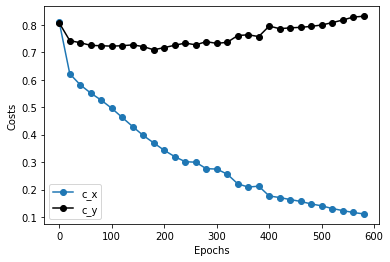

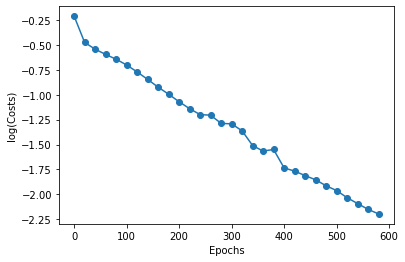

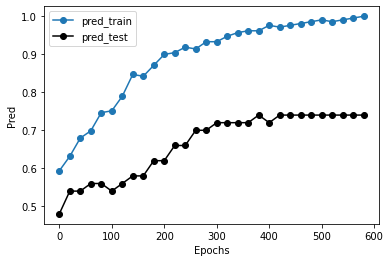

In [23]:
plt.plot(epochs, costs,"o-",label='c_x')
plt.plot(epochs, costs_y,"o-",color='black',label='c_y')
#plt.plot(epochs, accuracy_list,"o-",color='red',label='acc_x')
plt.legend()
plt.ylabel('Costs')
plt.xlabel('Epochs')
plt.show()

plt.plot(epochs, np.log(costs),"o-")
plt.ylabel('log(Costs)')
plt.xlabel('Epochs')
plt.show()

plt.plot(epochs, accuracy_list,"o-",label='pred_train')
plt.plot(epochs, accuracy_list_test,"o-",color='black',label='pred_test')
plt.legend()
plt.ylabel('Pred')
plt.xlabel('Epochs')
plt.show()

#Exercise 2, Accuracy on training and test set. 
In this exercise we ask you to monitor the value of the cost function and the accuracy on the training set and on the test set (the pictures that were not used during training).
1.   Create a list to plot the value of the cost function of your neural network over the training set as a function of the epochs. You can use: 
plt.plot(epochs, costs,"o-") ;
plt.ylabel('Costs_train');
plt.xlabel('Epochs');
plt.show()
2.   Create a list to plot the value of the cost function of your neural network over the test set as a function of the epochs. You can use: 
plt.plot(epochs, costs_test,"o-") ;
plt.ylabel('Costs_test');
plt.xlabel('Epochs');
plt.show()
3.   Create a list to plot the accuracy of your neural network on the training set and on the test set. 
4.   Use the following hyperparameters to train your neural network:  
*   learning_rate=0.0005 with, 
*   layers_dims = [12288, 100, 80 , 20, 5, 1],
*   train for 600 epochs (forward and backward iterations).
5.  Comment on your results. Did the cost function decrease monotonously? Did the accuracy increase? 

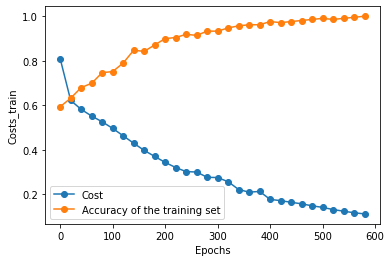

Accuracy on the training set at the last epoch : 99.99999999999997%


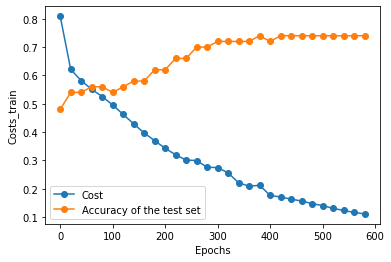

Accuracy on the test set at the last epoch : 74.0%
Cost at the end of the training: 0.11121718227027946


In [ ]:
plt.plot(epochs, costs,"o-",label = 'Cost')
plt.plot(epochs, accuracy_list,"o-",label = 'Accuracy of the training set')
plt.ylabel('Costs_train')
plt.xlabel('Epochs')
plt.legend()
plt.show()
print(f"Accuracy on the training set at the last epoch : {accuracy_list[-1]*100}%")

plt.plot(epochs, costs,"o-",label = 'Cost')
plt.plot(epochs, accuracy_list_test,"o-",label = 'Accuracy of the test set')
plt.ylabel('Costs_train')
plt.xlabel('Epochs')
plt.legend()
plt.show()

print(f"Accuracy on the test set at the last epoch : {accuracy_list_test[-1]*100}%")
print(f"Cost at the end of the training: {costs[-1]}")

In both case we can see a sharp increase at the beginning, going from 60% accurracy to 90% in ~ 250 epoch for the training set, and from ~50% to 70%  at the same time for the test set. 
This is a result we can expect, as it is easier for the NN to learn "the basic feature", than the rest.

Until then, it becomes harder for the NN to get more accurate, and the accuracy remains somewhat stable.

While we are able to reach ~100% accuracy for the training set, we only reach 74% for the test set. This can also be expected, as the training set is the one use the fine-tune the NN, and the NN "knows" the images, which is why we can reach almost 100% accuracy.
For the test set, the 74% can be increased only by tweaking some parameters, such as the amount of hidden layer, or their number of node in the hidden layers, but this almost becomes a game of "what if we try this combination?".

The Cost of the training however, seems to have decreased significantly from the beginning until the end, although we might see it slowing down, meaning in we trained it over 1000 epoch (or more), we can expect it to stabilize.


#Exercise 3, The effect of the learning rate.
In this exercise we ask you to test the effect of a different learning rate on the training. 
1.   Train your neural network for 600 epochs and plot the value of the cost function on the training set every 20 epochs with learning_rate=0.0005. Plot the figure that represents the cost function (on the y axis) and the number of epochs (on the x axis). Did your cost function decrease after each iteration? What end value of the cost function did you find?
2.   Repeat the same training after changing only the learning rate. Train your neural network for 600 epochs and plot the value of the cost function on the training set every 20 epochs with learning_rate=0.001. Plot the figure that represents the cost function (on the y axis) and the number of epochs (on the x axis). Did your cost function decrease after each iteration? What end value of the cost function did you find? 
3.   What difference did you notice? How can you explain this? 

Cost after iteration 0: 0.808839
Cost after iteration 100: 0.495812
Cost after iteration 200: 0.342880
Cost after iteration 300: 0.274615
Cost after iteration 400: 0.176569
Cost after iteration 500: 0.140602


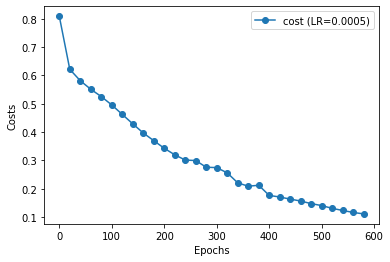

Cost at the end of the training with LR = 0.0005 : 0.11121718227027946
Cost after iteration 0: 0.808839
Cost after iteration 100: 0.433996
Cost after iteration 200: 0.333479
Cost after iteration 300: 0.461416
Cost after iteration 400: 0.097124
Cost after iteration 500: 0.085743


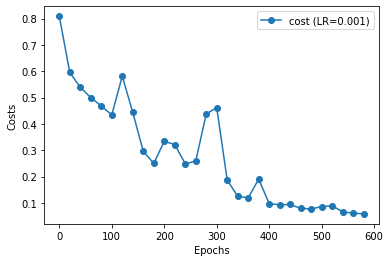

Cost at the end of the training with LR = 0.001 : 0.05798185349856905


In [ ]:
learning_rate = 0.0005
learning_rate, costs, costs_y, epochs, accuracy_list, accuracy_list_test = launch(layers_dims, learning_rate, num_iterations)

plt.plot(epochs, costs,"o-",label='cost (LR=0.0005)')
plt.legend()
plt.ylabel('Costs')
plt.xlabel('Epochs')
plt.show()

print(f"Cost at the end of the training with LR = 0.0005 : {costs[-1]}")

learning_rate = 0.001
learning_rate, costs, costs_y, epochs, accuracy_list, accuracy_list_test = launch(layers_dims, learning_rate, num_iterations)

plt.plot(epochs, costs,"o-",label='cost (LR=0.001)')
plt.legend()
plt.ylabel('Costs')
plt.xlabel('Epochs')
plt.show()

print(f"Cost at the end of the training with LR = 0.001 : {costs[-1]}")

While for the first training with the lower LR we can see an almost constant decrease after each iteration (considering each dot as 1 iteration, although they represent 20 actually), this is far from being the case for the larger LR. 
There are multiple time during the training where the cost went higher after an iteration, although in the end, the result is a cost twice as low (0.11 for the LR of 0.0005, and 0.058 for the LR of 0.001).
This can be explained because a larger LR means when the NN made a prediction, the changes inside the nodes of the NN will be bigger, which implies a risk of simply "overlapping the perfect value of the node". 
Which is why we tend to use smaller LR, but this is a the cost of more calculation during training, as it can lead to a need of using a higher amount of iteration to get the same result.

#Exercise 4, Optional. Adversarial training. 
This exercise is the last and most advance of this practical. We ask you to sum two images to see how this affects the prediction of your model. 

1.   The image of index=3 represents a flower, we call this im3. Plot the image of index=3 (as done in the first practical) to verify this. 
2.   After training your neural network, keep your neural network ready to make predictions. 
3.   Make a prediction for this image (you need to treat the image, flatten and /255). You are free to chose a good learning rate and a number of epochs. 
4.   The image of index=2 represents a cat, we call this im2. Plot the image of index 2 (as done in the first practical) to verify this. With the same neural network as before, make a prediction on image of index 2. 
5.   Create a new image with a noise summed to im2. Create im=$\alpha * im2+255 * np.random.rand(64,64,3)/2.$ with $\alpha=0.05$. This corresponds to the overlap of the image of a cat and of a random image.
Please plot this image. Can you see a cat? Perform a prediction using your neural network. What did your neural network predict? 
6.   Can you think of another interesting experiment using what you learned in the first two classes and describe it a few lines (less than 10 lines). If you have time perform this experiment and report your observations. 
 

y = [0], it's a 'non-cat' picture.


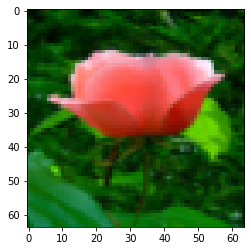

In [ ]:

1.
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.



index = 3
im3 = train_set_x_orig[index]
im3_y = train_set_y[:,index]

plt.imshow(im3)
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
2.
layers_dims = [12288, 100, 80 , 20, 5, 1]

learning_rate = 0.0005
num_iterations = 600

parameters, costs, costs_y, layers_dims, epochs, accuracy_list, accuracy_list_test = dnn(train_set_x, train_set_y, test_set_x, test_set_y, 
                                                                         layers_dims, learning_rate, num_iterations, print_cost=True)

Cost after iteration 0: 0.808839
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
Cost after iteration 100: 0.495812
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
Cost after iteration 200: 0.342880
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
Cost after iteration 300: 0.274615
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
Cost after iteration 400: 0.176569
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
Cost after iteration 500: 0.140602
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)
(12288, 50) (1, 50)


In [ ]:
3.
im3_adapt = np.expand_dims(im3, axis=0)
im3_flatten = im3_adapt.reshape(1, -1).T

im3_treat = im3_flatten/255

im3_test = np.expand_dims(im3_y, axis=0)

acc_im3 = predict(im3_treat, im3_test, parameters)

print("Prediction:",acc_im3)



1.0


y = [1], it's a 'cat' picture.
Prediction: 0.0


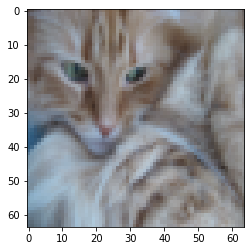

In [ ]:
4.
index2 = 2
im2 = train_set_x_orig[index2]
im2_y = train_set_y[:,index2]

plt.imshow(im2)
print ("y = " + str(train_set_y[:, index2]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index2])].decode("utf-8") +  "' picture.")

im2_adapt = np.expand_dims(im2, axis=0)
im2_flatten = im2_adapt.reshape(1, -1).T

im2_treat = im3_flatten/255

im2_test = np.expand_dims(im2_y, axis=0)

acc_im2 = predict(im2_treat, im2_test, parameters)

print("Prediction:",acc_im2)

The cat picture with an image superposed on it
Prediction: 1.0


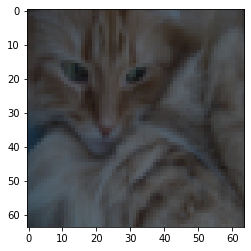

In [ ]:
5.
alpha = 0.5
matrix_rand = np.random.rand(64,64,3)
im = (alpha * im2) + (255 * matrix_rand.astype(int) )

im_trunc = np.trunc(im)
im_test = im_trunc.astype(int)

plt.imshow(im_test)
print ("The cat picture with an image superposed on it")

im_test_adapt = np.expand_dims(im_test, axis=0)
im_test_flatten = im_test_adapt.reshape(1, -1).T

im_test_treat = im_test_flatten/255

im2_test = np.expand_dims(im2_y, axis=0)

acc_test = predict(im_test_treat, im2_test, parameters)

print("Prediction:",acc_test)
